# RuntimeGuard – Example Simulations

This notebook demonstrates **RuntimeGuard** in realistic loop-heavy scenarios:

1. Particle physics simulation (CPU + RAM stress)
2. N-body gravity simulation (mean loop time + watchdog)
3. Intentional memory leak example (leak detection)
4. PyTorch Training
5. Ray Tracing with CIFAR-10

<br><br>

> Designed for Google Coolab

<br><br>

## Installation

In [1]:
!pip install runtime_guard

  Preparing metadata (setup.py) ... done
  Created wheel for runtime_guard: filename=runtime_guard-0.3-py3-none-any.whl size=12859 sha256=c6a6fe9db9a2cbe7792dcff7360c93a21e7571ba5663286aa1227c9cd127d56c
  Stored in directory: /root/.cache/pip/wheels/93/3c/5c/5034f2c7139796fe2863e71306d76cfef03b371aa72324f739
Successfully built runtime_guard


In [4]:
import random
import math
import time

import runtime_guard as run

guard = run.RuntimeGuard(
          make_ram_check=True, max_ram_usage_percentage=0.9,
          make_cpu_check=False, max_cpu_usage=0.9,
          make_gpu_check=True, max_gpu_usage=0.9,
          make_mean_loop_time_check=True, max_duration_factor_percentage=3.0, goal_mean_loop_time=-1.0, mean_loop_time_window_size=50,
          make_watchdog_timer_check=False, max_watchdog_seconds_timeout=-1, watchdog_seconds_waittime=30, # 5 minutes
          make_leak_check=True, max_leak_mb=100, max_leak_ratio=0.2,
          should_print=True, print_every_x_calls=100,
          should_log=False, log_every_x_calls=100, log_path="./runtime_guard.log",
          warm_up_iter=1, update_every_x_calls=100,
          hard_exit=False
)

## 1. Particle Physics Simulation

Simulates particles bouncing in a box using simple Newtonian physics.

In [5]:
N = 2000
particles = [
    {
        'x': random.random(),
        'y': random.random(),
        'vx': random.uniform(-1, 1),
        'vy': random.uniform(-1, 1)
    }
    for _ in range(N)
]

for step in range(500):
    guard.start_loop()

    for p in particles:
        p['x'] += p['vx'] * 0.01
        p['y'] += p['vy'] * 0.01

        if p['x'] < 0 or p['x'] > 1:
            p['vx'] *= -1
        if p['y'] < 0 or p['y'] > 1:
            p['vy'] *= -1

    guard.update()


Running Guard Check [19.12.2025 12:15]
    - RAM checked
        -> usage = 1.32 GB / 11.40 GB (11.60%)
    - No CPU Checking
    - GPU checked (TensorFlow) -> no GPU found
    - Mean Loop Time not yet collected
    - Calculating Basetime for Watchdog, then Watchdog will start.
    - Leak not checked because there is no last snapshot

Running Guard Check [19.12.2025 12:15]
    - RAM checked
        -> usage = 1.34 GB / 11.40 GB (11.77%)
    - No CPU Checking
    - GPU checked (TensorFlow) -> no GPU found
    - Mean Loop Time not yet collected
    - No Watchdog in use.
    - Leak checked
        -> Growth = 0.04 MB
        -> Ratio  = 0.35%
        -> Top leak sources:
            /usr/lib/python3.12/tracemalloc.py:558: size=27.8 KiB (+17.3 KiB), count=518 (+319), average=55 B
            /tmp/ipython-input-2568898980.py:20: size=35.8 KiB (+11.2 KiB), count=1526 (+479), average=24 B
            /tmp/ipython-input-2568898980.py:22: size=35.6 KiB (+10.9 KiB), count=1521 (+467), average=2

## 2. N-Body Gravity Simulation

This example stresses **mean loop time** and CPU usage.

In [6]:
guard = run.RuntimeGuard(
          make_ram_check=True, max_ram_usage_percentage=0.9,
          make_cpu_check=False, max_cpu_usage=0.9,
          make_gpu_check=True, max_gpu_usage=0.9,
          make_mean_loop_time_check=True, max_duration_factor_percentage=3.0, goal_mean_loop_time=-1.0, mean_loop_time_window_size=50,
          make_watchdog_timer_check=False, max_watchdog_seconds_timeout=-1, watchdog_seconds_waittime=30, # 5 minutes
          make_leak_check=True, max_leak_mb=100, max_leak_ratio=0.2,
          should_print=True, print_every_x_calls=100,
          should_log=False, log_every_x_calls=100, log_path="./runtime_guard.log",
          warm_up_iter=1, update_every_x_calls=100,
          hard_exit=False
)

In [7]:
bodies = [
    {
        'x': random.random(),
        'y': random.random(),
        'm': random.uniform(0.5, 2.0)
    }
    for _ in range(300)
]

G = 0.01

for step in range(200):
    with run.Run(guard):
        for i in range(len(bodies)):
            fx, fy = 0.0, 0.0
            for j in range(len(bodies)):
                if i == j:
                    continue
                dx = bodies[j]['x'] - bodies[i]['x']
                dy = bodies[j]['y'] - bodies[i]['y']
                dist = math.sqrt(dx*dx + dy*dy) + 1e-5
                f = G * bodies[j]['m'] / dist
                fx += f * dx
                fy += f * dy

            bodies[i]['x'] += fx * 0.001
            bodies[i]['y'] += fy * 0.001



Running Guard Check [19.12.2025 12:16]
    - RAM checked
        -> usage = 1.33 GB / 11.40 GB (11.70%)
    - No CPU Checking
    - GPU checked (TensorFlow) -> no GPU found
    - Mean Loop Time not yet collected
    - Calculating Basetime for Watchdog, then Watchdog will start.
    - Leak not checked because there is no last snapshot


## 3. Intentional Memory Leak Example

This loop intentionally leaks memory to demonstrate leak detection.


In [8]:
guard = run.RuntimeGuard(
          make_ram_check=True, max_ram_usage_percentage=0.9,
          make_cpu_check=True, max_cpu_usage=0.9,
          make_gpu_check=True, max_gpu_usage=0.9,
          make_mean_loop_time_check=True, max_duration_factor_percentage=3.0, goal_mean_loop_time=-1.0, mean_loop_time_window_size=50,
          make_watchdog_timer_check=False, max_watchdog_seconds_timeout=-1, watchdog_seconds_waittime=30, # 5 minutes
          make_leak_check=True, max_leak_mb=100, max_leak_ratio=0.2,
          should_print=True, print_every_x_calls=100,
          should_log=False, log_every_x_calls=100, log_path="./runtime_guard.log",
          warm_up_iter=1, update_every_x_calls=100,
          hard_exit=False
)

In [9]:
leak_container = []

for step in range(300):
    guard.start_loop()

    # Intentional leak
    leak_container.append([random.random() for _ in range(1000)])

    time.sleep(0.002)

    guard.update()


Running Guard Check [19.12.2025 12:18]
    - RAM checked
        -> usage = 1.30 GB / 11.40 GB (11.36%)
    - CPU checked
        -> usage = 11.20%
    - GPU checked (TensorFlow) -> no GPU found
    - Mean Loop Time not yet collected
    - Calculating Basetime for Watchdog, then Watchdog will start.
    - Leak not checked because there is no last snapshot


RuntimeError: [ABORT] Python memory leak detected. Details:

        -> Growth = 3.14 MB
        -> Ratio  = 21.54%
        -> Top leak sources:
            /tmp/ipython-input-3903474444.py:7: size=6451 KiB (+3210 KiB), count=201397 (+100200), average=33 B
            /usr/lib/python3.12/tracemalloc.py:558: size=33.3 KiB (+3152 B), count=663 (+57), average=51 B
            /usr/lib/python3.12/tracemalloc.py:560: size=536 B (+240 B), count=4 (+2), average=134 B
            /usr/lib/python3.12/tracemalloc.py:423: size=536 B (+240 B), count=4 (+2), average=134 B
            /usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py:230: size=4856 B (+216 B), count=44 (+3), average=110 B
            /usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py:219: size=4264 B (+120 B), count=38 (+1), average=112 B

## 4. PyTorch Training

In [10]:
!pip install torch torchvision

In [11]:
guard = run.RuntimeGuard(
          make_ram_check=True, max_ram_usage_percentage=0.9,
          make_cpu_check=False, max_cpu_usage=0.9,
          make_gpu_check=True, max_gpu_usage=0.9,
          make_mean_loop_time_check=True, max_duration_factor_percentage=3.0, goal_mean_loop_time=-1.0, mean_loop_time_window_size=50,
          make_watchdog_timer_check=False, max_watchdog_seconds_timeout=-1, watchdog_seconds_waittime=30, # 5 minutes
          make_leak_check=True, max_leak_mb=100, max_leak_ratio=0.2,
          should_print=False, print_every_x_calls=1,
          should_log=True, log_every_x_calls=1, log_path="./runtime_guard.log",
          warm_up_iter=1, update_every_x_calls=1,
          hard_exit=False
)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root="./data", train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

# Simple model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in guard(range(10)):
  # One training epoch
  model.train()
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

  print("Training step completed")


100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


Training step completed
Training step completed
Training step completed
Training step completed
Training step completed
Training step completed
Training step completed
Training step completed
Training step completed
Training step completed


In [13]:
with open("./runtime_guard.log", "r") as file_:
  print(file_.read())

Runtime Guard Configuration
- RAM Check: True (max 11.40 GB)
- CPU Check: False
- GPU Check: True (max usage 90.0%)
- Mean Loop Time Check: True
    -> max_duration_factor_percentage = 3.0
    -> goal_mean_loop_time = 0.0
    -> mean_loop_time_window_size = 50
- Watchdog Timer Check: False
- Memory Leak Check: True
    -> max_leak_mb = 100
    -> max_leak_ratio = 0.2
- Print enabled: False
- Logging enabled: True (every 1 calls, path='./runtime_guard.log')
- Warm-up iterations: 1
- Update every 1 calls
- Hard exit on failure: False


--------------------------------
Date: 19.12.2025
Time: 12:21
Loops: 1
    - RAM checked
        -> usage = 1.76 GB / 11.40 GB (15.42%)
    - No CPU Checking
    - GPU checked (TensorFlow) -> no GPU found
    - Mean Loop Time not yet collected
    - Calculating Basetime for Watchdog, then Watchdog will start.
    - Leak not checked because there is no last snapshot
--------------------------------

--------------------------------
Date: 19.12.2025
Time: 12

In [47]:
one_img = next(iter(train_loader))[0][0]

# unnormalize
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
one_img = one_img * std + mean

one_img.shape

torch.Size([3, 32, 32])

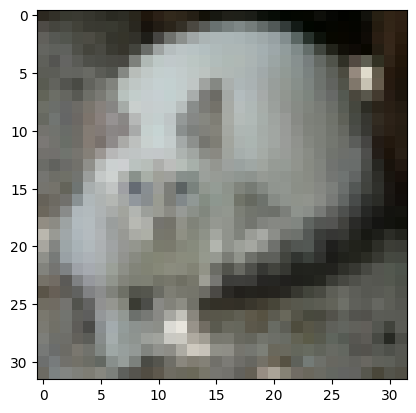

In [48]:
import matplotlib.pyplot as plt

plt.imshow(one_img.permute(1, 2, 0))

In [49]:
model(one_img.unsqueeze(0))

tensor([[ 0.5743, -4.6388,  1.5665,  0.5730, -0.9485,  1.6170, -1.7141,  1.1342,
         -3.1340, -0.6968]], grad_fn=<AddmmBackward0>)

## 5. Ray Tracing with CIFAR-10

In [57]:
guard = run.RuntimeGuard(
          make_ram_check=True, max_ram_usage_percentage=0.9,
          make_cpu_check=False, max_cpu_usage=0.9,
          make_gpu_check=True, max_gpu_usage=0.9,
          make_mean_loop_time_check=True, max_duration_factor_percentage=3.0, goal_mean_loop_time=-1.0, mean_loop_time_window_size=50,
          make_watchdog_timer_check=False, max_watchdog_seconds_timeout=-1, watchdog_seconds_waittime=30, # 5 minutes
          make_leak_check=True, max_leak_mb=100, max_leak_ratio=0.2,
          should_print=False, print_every_x_calls=1,
          should_log=True, log_every_x_calls=1, log_path="./runtime_guard.log",
          warm_up_iter=1, update_every_x_calls=1,
          hard_exit=False
)

In [34]:
!pip install img-phy-sim

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for img-phy-sim: filename=img_phy_sim-0.3-py3-none-any.whl size=32338 sha256=7a6c3ff7e8cd19d6765deccc98c2960914a7c5448a0ff18cff64385368b39f7c
  Stored in directory: /root/.cache/pip/wheels/a0/34/5a/17e3890836ee575bd75a80125e6fcdc615aa12ee99594226eb
Successfully built img-phy-sim


In [35]:
import img_phy_sim as ips

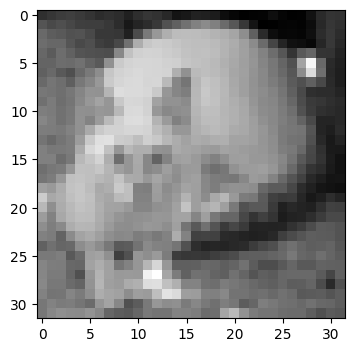

In [50]:
one_img = one_img[0]
ips.img.imshow(one_img, size=4, axis_off=False)

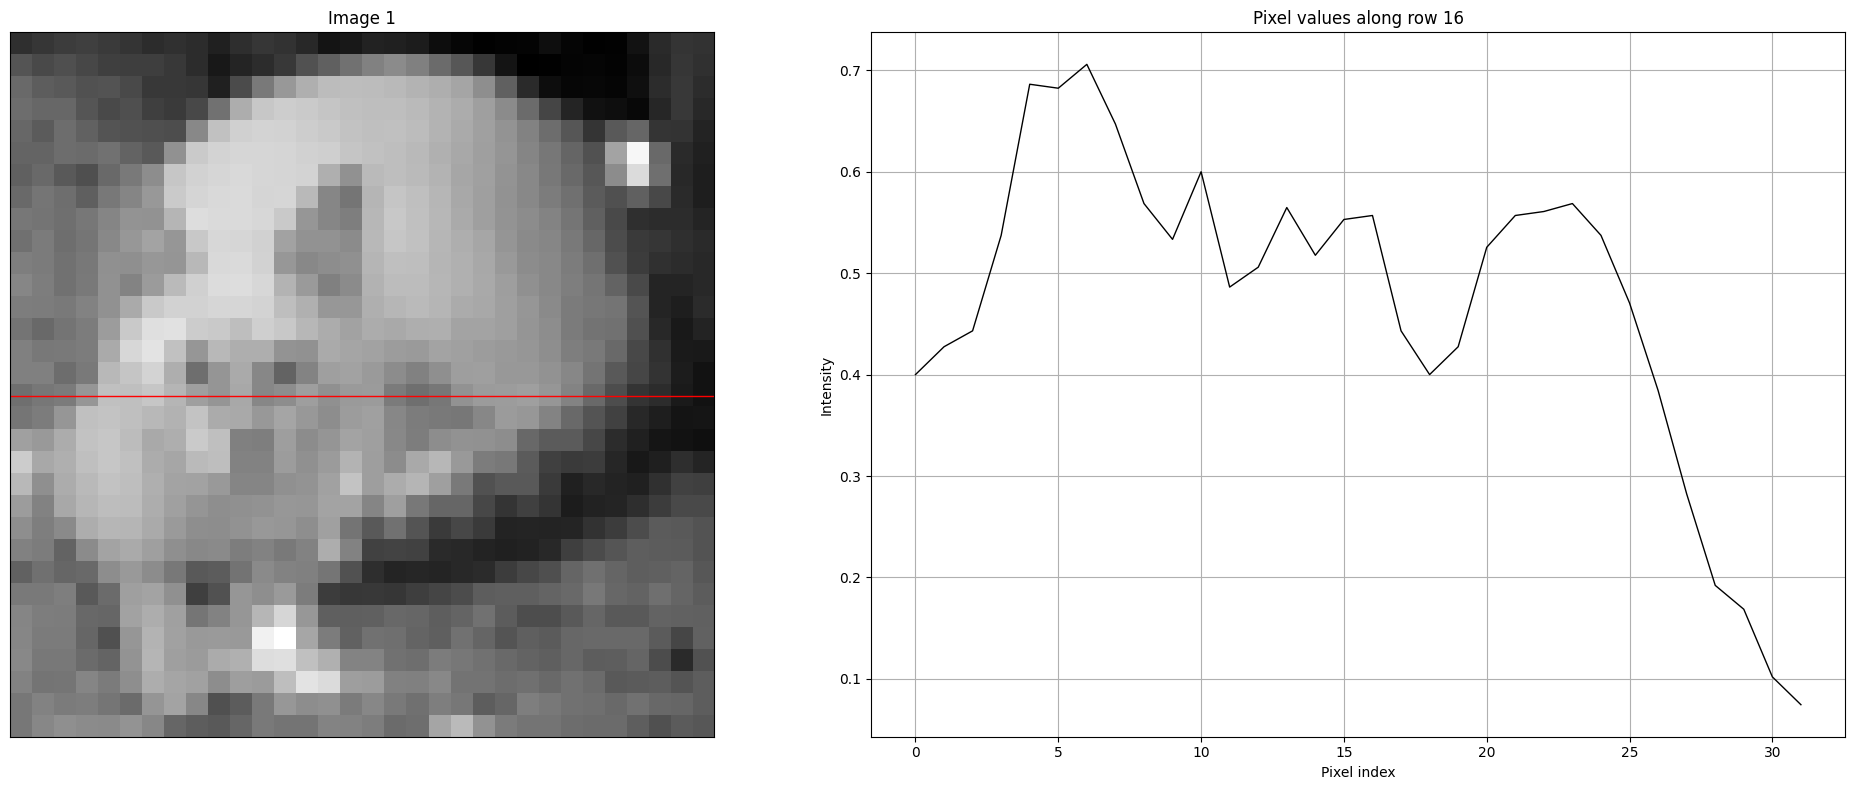

In [51]:
ips.img.show_image_with_line_and_profile(imgs=[one_img], axis='row', index=None, titles=None, figsize=(10, 8));

In [54]:
ips.img.save(one_img.numpy(), "./img.png")

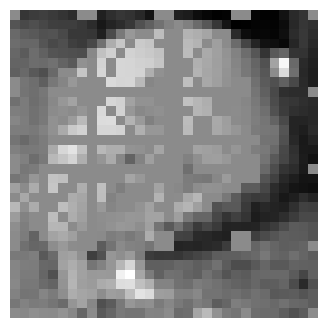

In [60]:
rays_ = None
max_ = 5
for x in guard(range(0, max_)):
    for y in range(0, max_):
        new_rays = ips.ray_tracing.trace_beams(rel_position=[x/(max_-1), y/(max_-1)],
                                                img_src="./img.png",
                                                directions_in_degree=ips.math.get_linear_degree_range(start=0, stop=360, step_size=45),
                                                wall_values=0.0,
                                                wall_thickness=0,
                                                img_border_also_collide=False,
                                                reflexion_order=2,
                                                should_scale_rays=True,
                                                should_scale_img=True)
        rays_ = ips.ray_tracing.merge(rays_, new_rays) if rays_ else new_rays

ray_img = ips.ray_tracing.draw_rays(rays_,
                                    detail_draw=False,
                                    output_format="single_image",
                                    img_background=one_img.numpy(), ray_value=0.5, ray_thickness=1,
                                    img_shape=(256, 256), dtype=float, standard_value=0,
                                    should_scale_rays_to_image=True, original_max_width=None, original_max_height=None)
ips.img.imshow(ray_img, size=4, cmap="gray")
del rays_

In [61]:
with open("./runtime_guard.log", "r") as file_:
  print(file_.read())

Runtime Guard Configuration
- RAM Check: True (max 11.40 GB)
- CPU Check: False
- GPU Check: True (max usage 90.0%)
- Mean Loop Time Check: True
    -> max_duration_factor_percentage = 3.0
    -> goal_mean_loop_time = 0.0
    -> mean_loop_time_window_size = 50
- Watchdog Timer Check: False
- Memory Leak Check: True
    -> max_leak_mb = 100
    -> max_leak_ratio = 0.2
- Print enabled: False
- Logging enabled: True (every 1 calls, path='./runtime_guard.log')
- Warm-up iterations: 1
- Update every 1 calls
- Hard exit on failure: False


--------------------------------
Date: 19.12.2025
Time: 12:44
Loops: 1
    - RAM checked
        -> usage = 2.55 GB / 11.40 GB (22.40%)
    - No CPU Checking
    - GPU checked (TensorFlow) -> no GPU found
    - Mean Loop Time not yet collected
    - Calculating Basetime for Watchdog, then Watchdog will start.
    - Leak not checked because there is no last snapshot
--------------------------------

--------------------------------
Date: 19.12.2025
Time: 12